# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




# Import Libraries

In [20]:
import warnings
import csv
import numpy as np
import pandas as pd


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10000)  # or 1000
pd.set_option('display.max_rows', 10000)  # or 1000
pd.set_option('display.max_colwidth', 10000)  # or 199


from matplotlib import pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, accuracy_score,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GroupShuffleSplit, LeaveOneGroupOut, KFold
from sklearn.feature_selection import RFE, SelectFromModel, RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from collections import Counter

# Load data

In [21]:
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

# Plotting data in 2D with axes sampled 
## a) At random 
## b) From same electrode
## c) From same feature type

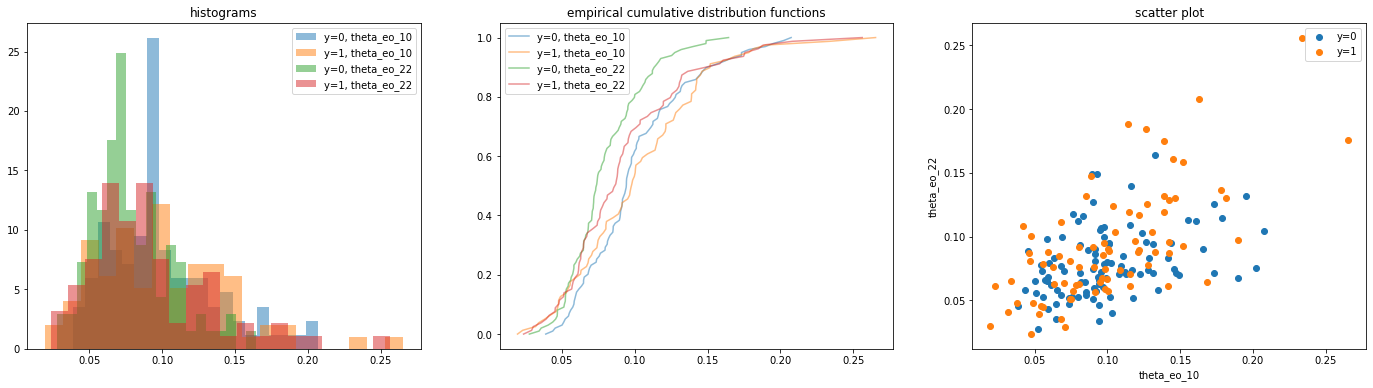

In [22]:
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

#b) same electrode, different feature (uncomment lines below)
f0, f1 = np.random.randint(0, num_features, size=2)
e = np.random.randint(0, num_electrodes)
i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

#c) same feature, different electrode (uncomment lines below)
f = np.random.randint(0, num_features)
e0, e1 = np.random.randint(0, num_electrodes, size=2)
i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

# Defining Models and Cross Validation Scheme

In [4]:
models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
        ]

clf = SVC(kernel='linear')
kf = KFold(n_splits=18, shuffle=False)

# Evaluation Function

In [5]:
def evaluate(models, data, kf):
    result_list = []
    for name, model in models:
        sens, spec, acc = [],[],[]
        y_true, y_pred = [],[]

        for train_index, test_index in kf.split(data):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train,y_train)
            y_predict = model.predict(X_test)

            y_pred.append(y_predict)
            y_true.append(y_test)

            acc.append(accuracy_score(y_test, y_predict))

        flat_y_true = []
        for sublist in y_true:
            for item in sublist:
                flat_y_true.append(item)

        flat_y_pred = []
        for sublist in y_pred:
            for item in sublist:
                flat_y_pred.append(item)

        y_true = flat_y_true
        y_pred = flat_y_pred

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

        result_dict = {}
        result_dict["model"] = name
        result_dict["accuracy"] = np.mean(acc)
        result_dict["specificity"] = tn / (tn+fp)
        result_dict["sensitivity"] = tp / (tp+fn)
        result_dict["auc"] = auc(fpr, tpr)
        result_list.append(result_dict)

    results = pd.DataFrame.from_dict(result_list)
    return results

# Baseline Benchmark.

In [6]:
results = evaluate(models, X, kf)
results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.855556,0.88,0.8250,0.85250
1,RF,0.816667,0.87,0.7500,0.81000
2,KNN,0.688889,0.77,0.5875,0.67875
3,SVM,0.661111,0.64,0.6875,0.66375
4,GNB,0.750000,0.82,0.6625,0.74125


# Using RFECV to find optimal value of K on original dataset

Optimal number of features : 322


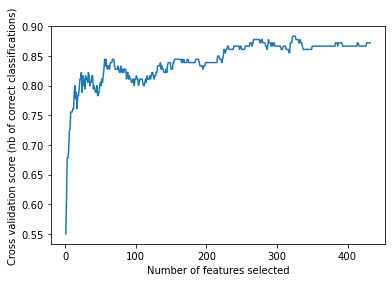

In [7]:
rfecv = RFECV(estimator=clf, step=1, cv= kf.split(X), scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# ANOVA filter method on original dataset.

In [8]:
anova = SelectKBest(f_classif, k=rfecv.n_features_) 
anova_data = anova.fit_transform(X, y)
features = anova.get_support(indices=True)
anova_data = X[:,features]  
anova_results = evaluate(models, anova_data, kf)
anova_results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.838889,0.84,0.8375,0.83875
1,RF,0.838889,0.86,0.8125,0.83625
2,KNN,0.744444,0.82,0.6500,0.73500
3,SVM,0.633333,0.63,0.6375,0.63375
4,GNB,0.761111,0.83,0.6750,0.75250


# ANOVA + RFE

Optimal number of features : 51


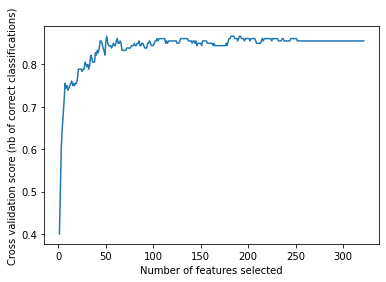

In [9]:
rfecv = RFECV(estimator=clf, step=1, cv=kf.split(anova_data),scoring='accuracy')
rfecv.fit(anova_data, y)
print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [10]:
selector = RFE(clf, rfecv.n_features_, step=1)
selector = selector.fit(anova_data, y)  
cols = selector.support_
anova_rfe_data = anova_data[:,cols]
anova_rfe_results = evaluate(models, anova_rfe_data, kf)
anova_rfe_results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.933333,0.93,0.9375,0.93375
1,RF,0.861111,0.88,0.8375,0.85875
2,KNN,0.727778,0.79,0.6500,0.72000
3,SVM,0.722222,0.70,0.7500,0.72500
4,GNB,0.783333,0.87,0.6750,0.77250


# Mutual Information filter method on original dataset.

In [11]:
mutual_info = SelectKBest(mutual_info_classif, k=rfecv.n_features_)
mutual_info_data = mutual_info.fit_transform(X, y)
features = mutual_info.get_support(indices=True)
mutual_info_data = X[:,features] 
mutual_info_results = evaluate(models, mutual_info_data, kf)
mutual_info_results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.794444,0.82,0.7625,0.79125
1,RF,0.816667,0.81,0.8250,0.81750
2,KNN,0.716667,0.80,0.6125,0.70625
3,SVM,0.677778,0.64,0.7250,0.68250
4,GNB,0.766667,0.87,0.6375,0.75375


# Mutual Info + RFE

Optimal number of features : 31


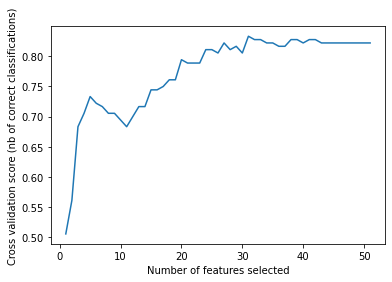

In [12]:
rfecv = RFECV(estimator=clf, step=1, cv=kf.split(anova_data),scoring='accuracy')
rfecv.fit(mutual_info_data, y)
print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [13]:
selector = RFE(clf, rfecv.n_features_, step=1) 
selector = selector.fit(mutual_info_data, y)  
cols = selector.support_
mutual_info_rfe_data = mutual_info_data[:,cols]
mutual_info_rfe_results = evaluate(models, mutual_info_rfe_data, kf)
mutual_info_rfe_results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.788889,0.87,0.6875,0.77875
1,RF,0.827778,0.82,0.8375,0.82875
2,KNN,0.733333,0.80,0.6500,0.72500
3,SVM,0.750000,0.80,0.6875,0.74375
4,GNB,0.772222,0.82,0.7125,0.76625


# Lasso embedded method feature selection on original dataset.

In [14]:
lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
importance = importance[importance > 0]
features = np.where(importance != 0)[0]
lasso_data = X[:,features]
lasso_results = evaluate(models, lasso_data, kf)
lasso_results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.727778,0.78,0.6625,0.72125
1,RF,0.800000,0.85,0.7375,0.79375
2,KNN,0.777778,0.80,0.7500,0.77500
3,SVM,0.705556,0.72,0.6875,0.70375
4,GNB,0.583333,0.63,0.5250,0.57750


# Random Forest based feature selection on original data.

In [15]:
rf_clf = RandomForestClassifier(n_estimators=2000, random_state=0, n_jobs=-1)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#Train the classifier
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=0)

In [16]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(feature_names, rf_clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance',ascending=False)
importances.head(10)

,Gini-importance
ratio_beta_5,0.017286
ratio_beta_34,0.015667
ratio_beta_4,0.014473
theta_ec_25,0.013492
ratio_beta_35,0.012141
ratio_beta_0,0.011172
ratio_alpha_9,0.009416
ratio_beta_1,0.008670
ratio_beta_37,0.008425
alpha_eo_9,0.008200


In [17]:
# Create a selector object that will use the random forest classifier to identify
sfm = SelectFromModel(rf_clf)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=2000, n_jobs=-1,
                                                 random_state=0))

# Number of features after filtering

In [18]:
print(len(sfm.get_support(indices=True)))

138


In [19]:
rf_importance_data = sfm.transform(X)
rf_importance_results = evaluate(models, rf_importance_data, kf)
rf_importance_results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.838889,0.85,0.8250,0.83750
1,RF,0.838889,0.87,0.8000,0.83500
2,KNN,0.766667,0.80,0.7250,0.76250
3,SVM,0.761111,0.75,0.7750,0.76250
4,GNB,0.777778,0.85,0.6875,0.76875


# Projection Methods for Feature Extraction.

# PCA

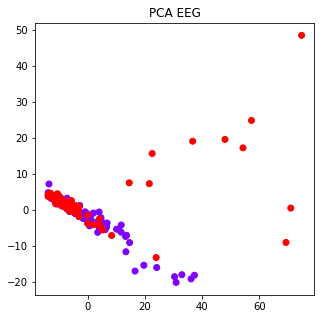

In [27]:
import sklearn
plt.figure(figsize=(5,5))
plt.title("PCA EEG")

# apply principal component analysis
pca = sklearn.decomposition.PCA(n_components=2).fit(X)
X_2d = pca.transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')

Text(0, 0.5, 'Proportion of variance explained')

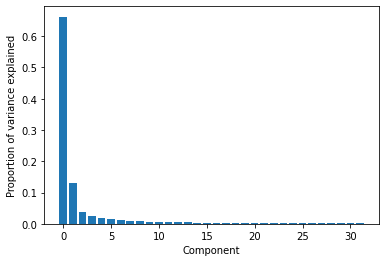

In [28]:
pca = sklearn.decomposition.PCA(n_components=32).fit(X)
plt.bar(np.arange(32), pca.explained_variance_ratio_)
plt.xlabel("Component")
plt.ylabel("Proportion of variance explained")

# TSNE

Text(0.5, 1.0, 'EEG tSNE')

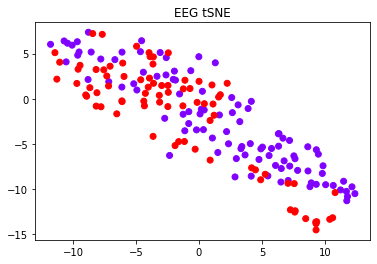

In [32]:
import sklearn.manifold
tsne  = sklearn.manifold.TSNE()
X_2d = tsne.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("EEG tSNE")

# UMAP

Text(0.5, 1.0, 'UMAP tSNE')

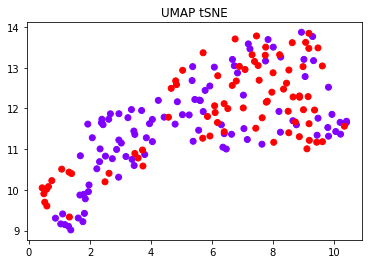

In [35]:
import umap.umap_ as umap
umap  = umap.UMAP(min_dist=0.2)
X_2d = umap.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("UMAP tSNE")